In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

In [2]:
df = pd.read_csv("Housing.csv")

In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
nominal_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']

df[nominal_cols] = df[nominal_cols].replace({"yes": 1, "no": 0})

C:\Users\audih\AppData\Local\Temp\ipykernel_19076\201093094.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[nominal_cols] = df[nominal_cols].replace({"yes": 1, "no": 0})


In [6]:
df['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [7]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df['furnishingstatus'] = le.fit_transform(df['furnishingstatus'])

furnishingstatus_order = {'furnished' : 2, 'semi-furnished': 1, 'unfurnished': 0}
df['furnishingstatus'] = df['furnishingstatus'].map(furnishingstatus_order)

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
mainroad,545.0,8.587156e-01,3.486347e-01,0.0,1.0,1.0,1.0,1.0
guestroom,545.0,1.779817e-01,3.828487e-01,0.0,0.0,0.0,0.0,1.0
basement,545.0,3.504587e-01,4.775519e-01,0.0,0.0,0.0,1.0,1.0
hotwaterheating,545.0,4.587156e-02,2.093987e-01,0.0,0.0,0.0,0.0,1.0
airconditioning,545.0,3.155963e-01,4.651799e-01,0.0,0.0,0.0,1.0,1.0


In [9]:
X = df.drop(columns=['price'])
y = df[["price"]].astype(float).values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

In [12]:
# scale_cols = ['price','area']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train[ ['area'] ] = scaler_X.fit_transform(X_train[['area']])
X_val  [['area'] ] = scaler_X.transform(X_val[['area']])
X_test [['area'] ] = scaler_X.transform(X_test[['area']])

In [13]:
y_train = scaler_y.fit_transform(y_train)
y_val   = scaler_y.transform(y_val)
y_test  = scaler_y.transform(y_test)

In [14]:
X_train_array = np.array(X_train).T
Y_train_array = np.array(y_train).T


In [15]:
X_val_array = np.array(X_val).T
Y_val_array = np.array(y_val).T

In [ ]:
#NEURAL NETWORKS

def init_params(input_dim, hidden_neuron=32, method = "xavier", rng=None):
    if rng is None:
        rng = np.random.default_rng(42)

    if method == "he":
        W1 = rng.standard_normal((hidden_neuron, input_dim)) * np.sqrt(2.0 / input_dim)
        W2 = rng.standard_normal((1, hidden_neuron)) * np.sqrt(2.0 / hidden_neuron)
    
    elif method == "xavier":
        W1 = np.random.randn(hidden_neuron, input_dim) * np.sqrt(1.0 / input_dim)
        W2 = np.random.randn(1, hidden_neuron) * np.sqrt(1.0 / hidden_neuron)

    # b1 = np.random.rand(hidden_neuron,1) #inisialisasi bias untuk layer 1
    # b2 = np.random.rand(1,1) #inisialisasi bias untuk layer 2
    b1 = np.zeros((hidden_neuron, 1))
    b2 = np.zeros((1, 1))

    return W1, b1, W2, b2



def leaky_relu(Z,alpha=0.1):
    return np.maximum(alpha*Z, Z)

def deriv_leaky_relu(Z, alpha=0.1):
    grad = np.ones_like(Z)
    grad[Z < 0] = alpha
    return grad

def linear(Z):
    return Z

def relu(Z):
    return np.maximum(0, Z)

def deriv_relu(Z):
    return Z > 0

def tanh(Z):
    return np.tanh(Z)

def deriv_tanh(Z):
    A = np.tanh(Z)
    return 1 - np.power(A,2)


def forward(W1, b1, W2, b2, X, activation = relu):
    if activation == "tanh":
            '''
            Layer 1
            '''
            #Z1 adalah sum dari layer 1
            Z1 = W1.dot(X) + b1
            #A1 adalah output dari layer 1
            A1 = tanh(Z1)

            '''
            Layer 2
            '''
            Z2 = W2.dot(A1) + b2
            A2 = linear(Z2)

            return Z1, A1, Z2, A2
    elif activation == "leaky_relu":
            '''
            Layer 1
            '''
            #Z1 adalah sum dari layer 1
            Z1 = W1.dot(X) + b1
            #A1 adalah output dari layer 1
            A1 = leaky_relu(Z1,alpha=0.1)

            '''
            Layer 2
            '''
            Z2 = W2.dot(A1) + b2
            A2 = linear(Z2)

            return Z1, A1, Z2, A2
    
    '''
    Layer 1
    '''
    #Z1 adalah sum dari layer 1
    Z1 = W1.dot(X) + b1
    #A1 adalah output dari layer 1
    A1 = relu(Z1)

    '''
    Layer 2
    '''
    Z2 = W2.dot(A1) + b2
    A2 = linear(Z2)

    return Z1, A1, Z2, A2

def backpropagation(Z1, A1, Z2, A2, W2, X, Y, activation = relu):
    if activation == "leaky_relu":
        m = Y.size
        dZ2 = A2 - Y
        dW2 = (1/m) * dZ2.dot(A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True) 

        dZ1 = W2.T.dot(dZ2) * deriv_leaky_relu(Z1,alpha=0.1)
        dW1 = (1/m) * dZ1.dot(X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True) 

        return dW1, db1, dW2, db2
    
    elif activation == "tanh":
        m = Y.size
        dZ2 = A2 - Y
        dW2 = (1/m) * dZ2.dot(A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True) 

        dZ1 = W2.T.dot(dZ2) * deriv_tanh(Z1)
        dW1 = (1/m) * dZ1.dot(X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True) 

        return dW1, db1, dW2, db2
         
    m = Y.size
    dZ2 = A2 - Y
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True) 

    dZ1 = W2.T.dot(dZ2) * deriv_relu(Z1)
    dW1 = (1/m) * dZ1.dot(X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True) 

    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    new_W1 = W1 - alpha * dW1
    new_b1 = b1 - alpha * db1
    new_W2 = W2 - alpha * dW2
    new_b2 = b2 - alpha * db2
    
    return new_W1, new_b1, new_W2, new_b2



In [17]:
#GRADIENT DESCENT
# fungsi untuk mengubah output aktivasi menjadi prediksi akhir
def get_prediction(A2):
    """
    Karena ini regresi, prediksi = output langsung
    """
    return A2

# fungsi untuk menghitung error (contoh MSE)
def get_error(prediction, Y, loss="mse"):
    """
    Menghitung loss antara prediksi dan target.
    prediction, Y: shape (1, m)
    """

    pred_real = scaler_y.inverse_transform(prediction.T)
    y_real    = scaler_y.inverse_transform(Y.T)

    if loss == "mse":
        return np.mean((pred_real - y_real) ** 2)
    elif loss == "mae":
        return np.mean(np.abs(pred_real - y_real))
    else:
        raise ValueError("Unknown loss type")

In [24]:
# === util kecil ===
def _ensure_final_mae(W1,b1,W2,b2, X, Y, X_val, Y_val, activation, train_mae, val_mae):
    if train_mae is None or val_mae is None:
        _, _, _, A2_train = forward(W1, b1, W2, b2, X,      activation=activation)
        _, _, _, A2_val   = forward(W1, b1, W2, b2, X_val,  activation=activation)
        train_mae = get_error(get_prediction(A2_train), Y,      loss="mae")
        val_mae   = get_error(get_prediction(A2_val),   Y_val,  loss="mae")
    return float(train_mae), float(val_mae)

def batch_gradient_descent(X, Y, epochs, lr, hidden_neuron, activation, winit, log_every=1):
    input_dim = X.shape[0]
    W1, b1, W2, b2 = init_params(input_dim, hidden_neuron, method=winit)

    # riwayat
    hist_train, hist_val = [], []
    train_mae = None
    val_mae   = None

    for i in range(1, epochs+1):
        Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, X, activation=activation)
        dW1, db1, dW2, db2 = backpropagation(Z1, A1, Z2, A2, W2, X, Y, activation=activation)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

        # hitung metrik tiap epoch (atau setiap log_every)
        if (i % log_every) == 0:
            pred_train = get_prediction(A2)
            train_mae  = get_error(pred_train, Y, loss="mae")
            _, _, _, A2_val = forward(W1, b1, W2, b2, X_val_array, activation=activation)
            pred_val   = get_prediction(A2_val)
            val_mae    = get_error(pred_val, Y_val_array, loss="mae")
            hist_train.append(float(train_mae))
            hist_val.append(float(val_mae))
            if (i % 10) == 0:
                print(f"Iter {i:4d} | Train MAE = {train_mae:.4f} | Val MAE = {val_mae:.4f}")

    train_mae, val_mae = _ensure_final_mae(W1,b1,W2,b2, X,Y, X_val_array,Y_val_array, activation, train_mae, val_mae)

    # results_df = pd.DataFrame([{
    #     "mode": "Batch_Gradient_Descent",
    #     "weight initialization": winit,
    #     "activation": activation,
    #     "learning_rate": lr,
    #     "train_mae": train_mae,
    #     "val_mae": val_mae,
    # }])

    # results_csv = "results3.csv"
    # if not os.path.isfile(results_csv):
    #     results_df.to_csv(results_csv, index=False, mode='w', header=True)
    # else:
    #     results_df.to_csv(results_csv, index=False, mode='a', header=False)
    # print(f"\nSaved results to {results_csv}")

    # kembalikan juga history untuk plotting
    history = {"train_mae": hist_train, "val_mae": hist_val, "log_every": log_every}
    return W1, b1, W2, b2, history

def stoch_gradient_descent(X, Y, epochs, lr, hidden_neuron, activation, winit, shuffle=True, seed=42, log_every=1):
    input_dim = X.shape[0]
    rng = np.random.default_rng(seed)
    n = X.shape[1]
    W1, b1, W2, b2 = init_params(input_dim, hidden_neuron, method=winit)

    hist_train, hist_val = [], []
    train_mae = None
    val_mae   = None

    for i in range(1, epochs+1):
        idx = np.arange(n)
        if shuffle:
            rng.shuffle(idx)

        for start in range(0, n, 1):  # SGD murni
            batch_idx = idx[start:start+1]
            Xb = X[:, batch_idx]
            Yb = Y[:, batch_idx] if Y.ndim == 2 else Y[batch_idx]
            Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, Xb, activation=activation)
            dW1, db1, dW2, db2 = backpropagation(Z1, A1, Z2, A2, W2, Xb, Yb, activation=activation)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

        if (i % log_every) == 0:
            _, _, _, A2_train = forward(W1, b1, W2, b2, X, activation=activation)
            _, _, _, A2_val   = forward(W1, b1, W2, b2, X_val_array, activation=activation)
            train_mae = get_error(get_prediction(A2_train), Y, loss="mae")
            val_mae   = get_error(get_prediction(A2_val),   Y_val_array, loss="mae")
            hist_train.append(float(train_mae))
            hist_val.append(float(val_mae))
            if (i % 10) == 0:
                print(f"Epoch {i:4d} | Train MAE = {train_mae:.4f} | Val MAE = {val_mae:.4f}")

    train_mae, val_mae = _ensure_final_mae(W1,b1,W2,b2, X,Y, X_val_array,Y_val_array, activation, train_mae, val_mae)

    # results_df = pd.DataFrame([{
    #     "mode": "Stochastic_Gradient_Descent",
    #     "weight initialization": winit,
    #     "activation": activation,
    #     "learning_rate": lr,
    #     "train_mae": train_mae,
    #     "val_mae": val_mae,
    # }])

    # results_csv = "results3.csv"
    # if not os.path.isfile(results_csv):
    #     results_df.to_csv(results_csv, index=False, mode='w', header=True)
    # else:
    #     results_df.to_csv(results_csv, index=False, mode='a', header=False)
    # print(f"\nSaved results to {results_csv}")

    history = {"train_mae": hist_train, "val_mae": hist_val, "log_every": log_every}
    return W1, b1, W2, b2, history

def mini_batch_gradient_descent(X, Y, epochs, lr, hidden_neuron, activation, winit, batch_size=32, shuffle=True, seed=42, log_every=1):
    rng = np.random.default_rng(seed)
    n = X.shape[1]
    input_dim = X.shape[0]
    W1, b1, W2, b2 = init_params(input_dim, hidden_neuron, method=winit)

    hist_train, hist_val = [], []
    train_mae = None
    val_mae   = None

    for i in range(1, epochs+1):
        idx = np.arange(n)
        if shuffle:
            rng.shuffle(idx)

        for start in range(0, n, batch_size):
            batch_idx = idx[start:start+batch_size]
            Xb = X[:, batch_idx]
            Yb = Y[:, batch_idx] if Y.ndim == 2 else Y[batch_idx]
            Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, Xb, activation=activation)
            dW1, db1, dW2, db2 = backpropagation(Z1, A1, Z2, A2, W2, Xb, Yb, activation=activation)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

        if (i % log_every) == 0:
            _, _, _, A2_train = forward(W1, b1, W2, b2, X, activation=activation)
            _, _, _, A2_val   = forward(W1, b1, W2, b2, X_val_array, activation=activation)
            train_mae = get_error(get_prediction(A2_train), Y, loss="mae")
            val_mae   = get_error(get_prediction(A2_val),   Y_val_array, loss="mae")
            hist_train.append(float(train_mae))
            hist_val.append(float(val_mae))
            if (i % 10) == 0:
                print(f"Epoch {i:4d} | Train MAE = {train_mae:.4f} | Val MAE = {val_mae:.4f}")

    train_mae, val_mae = _ensure_final_mae(W1,b1,W2,b2, X,Y, X_val_array,Y_val_array, activation, train_mae, val_mae)

    # results_df = pd.DataFrame([{
    #     "mode": "Mini_Batch_Gradient_Descent",
    #     "weight initialization": winit,
    #     "activation": activation,
    #     "learning_rate": lr,
    #     "batch_size": batch_size,
    #     "train_mae": train_mae,
    #     "val_mae": val_mae,
    # }])

    # results_csv = "results3.csv"
    # if not os.path.isfile(results_csv):
    #     results_df.to_csv(results_csv, index=False, mode='w', header=True)
    # else:
    #     results_df.to_csv(results_csv, index=False, mode='a', header=False)
    # print(f"\nSaved results to {results_csv}")

    history = {"train_mae": hist_train, "val_mae": hist_val, "log_every": log_every}
    return W1, b1, W2, b2, history


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(history, title="Learning Curve (MAE)"):
    """
    history: dict dengan keys 'train_mae', 'val_mae', 'log_every'
    """
    train = history.get("train_mae", [])
    val   = history.get("val_mae", [])
    every = int(history.get("log_every", 1))

    if len(train) == 0 or len(val) == 0:
        print("History kosong: pastikan log_every menghasilkan riwayat.")
        return

    # x-axis dalam epoch asli (bukan index log)
    epochs_axis = np.arange(every, every*len(train)+1, every)

    plt.figure(figsize=(7,4.5))
    plt.plot(epochs_axis, train, label="Train MAE")
    plt.plot(epochs_axis, val,   label="Val MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (skala asli y)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Iter   10 | Train MAE = 2316516.9050 | Val MAE = 2445367.8364
Iter   20 | Train MAE = 2229887.1372 | Val MAE = 2359573.2410
Iter   30 | Train MAE = 2159056.6220 | Val MAE = 2288537.2115
Iter   40 | Train MAE = 2100025.1523 | Val MAE = 2227795.6355
Iter   50 | Train MAE = 2049530.7424 | Val MAE = 2171894.2920
Iter   60 | Train MAE = 2004457.9000 | Val MAE = 2119882.2004
Iter   70 | Train MAE = 1962673.2385 | Val MAE = 2071188.3283
Iter   80 | Train MAE = 1924164.6456 | Val MAE = 2024722.9016
Iter   90 | Train MAE = 1887944.1492 | Val MAE = 1981461.1179
Iter  100 | Train MAE = 1853242.2076 | Val MAE = 1940091.6327


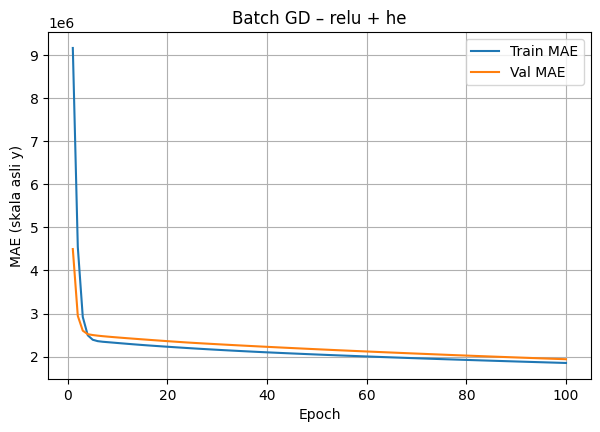

Iter   10 | Train MAE = 3357264.4492 | Val MAE = 3527188.9213
Iter   20 | Train MAE = 3061171.3204 | Val MAE = 3216713.8256
Iter   30 | Train MAE = 2827174.5594 | Val MAE = 2959315.1720
Iter   40 | Train MAE = 2640719.5913 | Val MAE = 2740171.8987
Iter   50 | Train MAE = 2492901.2676 | Val MAE = 2551806.8491
Iter   60 | Train MAE = 2376137.9306 | Val MAE = 2412417.9937
Iter   70 | Train MAE = 2281134.5615 | Val MAE = 2298533.8139
Iter   80 | Train MAE = 2202748.8733 | Val MAE = 2197423.9388
Iter   90 | Train MAE = 2135420.7424 | Val MAE = 2108261.8782
Iter  100 | Train MAE = 2076015.3668 | Val MAE = 2030837.5408


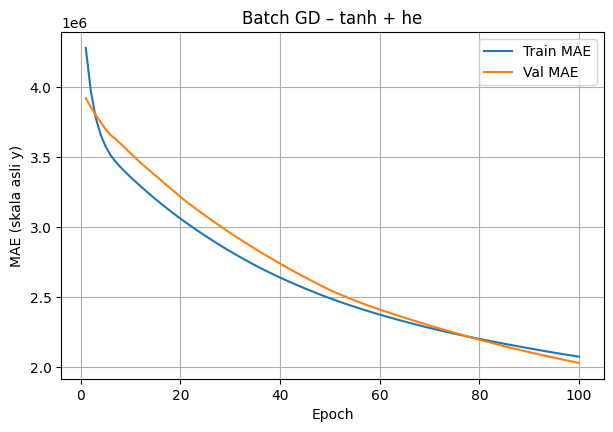

Iter   10 | Train MAE = 2316516.9050 | Val MAE = 2445367.8364
Iter   20 | Train MAE = 2229887.1372 | Val MAE = 2359573.2410
Iter   30 | Train MAE = 2159056.6220 | Val MAE = 2288537.2115
Iter   40 | Train MAE = 2100025.1523 | Val MAE = 2227795.6355
Iter   50 | Train MAE = 2049530.7424 | Val MAE = 2171894.2920
Iter   60 | Train MAE = 2004457.9000 | Val MAE = 2119882.2004
Iter   70 | Train MAE = 1962673.2385 | Val MAE = 2071188.3283
Iter   80 | Train MAE = 1924164.6456 | Val MAE = 2024722.9016
Iter   90 | Train MAE = 1887944.1492 | Val MAE = 1981461.1179
Iter  100 | Train MAE = 1853242.2076 | Val MAE = 1940091.6327


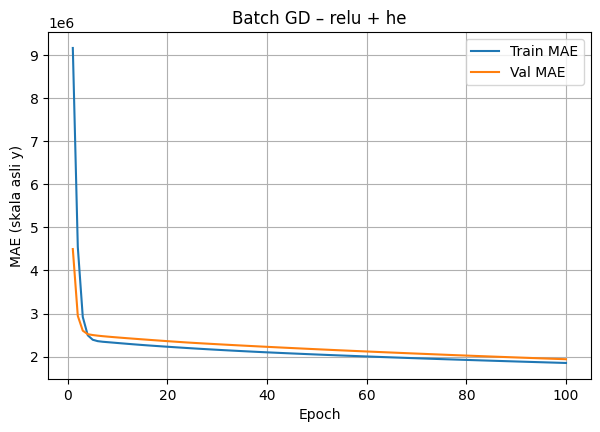

In [26]:
#BATCH GRADIENT DESCENT
#relu
W1, b1, W2, b2, hist_batch = batch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='relu', winit='he',
    log_every=1
)
plot_learning_curve(hist_batch, title="Batch GD – relu + he")

#tanh
W1, b1, W2, b2, hist_batch = batch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='tanh', winit='he',
    log_every=1
)
plot_learning_curve(hist_batch, title="Batch GD – tanh + he")

#leaky relu
W1, b1, W2, b2, hist_batch = batch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='relu', winit='he',
    log_every=1
)
plot_learning_curve(hist_batch, title="Batch GD – relu + he")

Epoch   10 | Train MAE = 796705.4060 | Val MAE = 828511.6275
Epoch   20 | Train MAE = 751877.2735 | Val MAE = 793248.9434
Epoch   30 | Train MAE = 746321.0387 | Val MAE = 778190.7808
Epoch   40 | Train MAE = 978112.9721 | Val MAE = 981070.3531
Epoch   50 | Train MAE = 743643.7655 | Val MAE = 766680.4949
Epoch   60 | Train MAE = 694315.3315 | Val MAE = 721454.3060
Epoch   70 | Train MAE = 702161.4591 | Val MAE = 690549.1551
Epoch   80 | Train MAE = 746372.2892 | Val MAE = 746994.2631
Epoch   90 | Train MAE = 725383.4018 | Val MAE = 689940.5787
Epoch  100 | Train MAE = 691041.0958 | Val MAE = 696035.2338


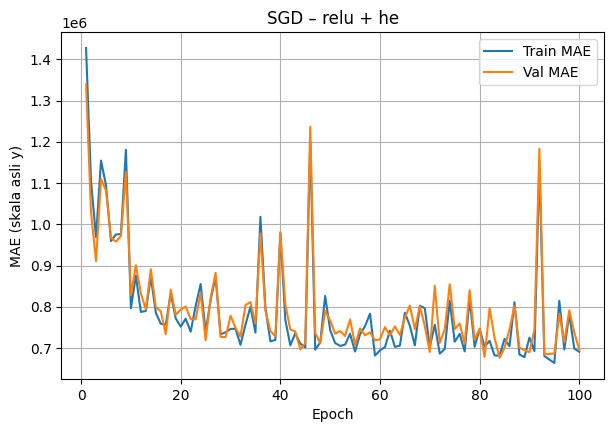

Epoch   10 | Train MAE = 928706.6111 | Val MAE = 904431.2047
Epoch   20 | Train MAE = 819943.7319 | Val MAE = 810561.6450
Epoch   30 | Train MAE = 777920.0806 | Val MAE = 711535.4387
Epoch   40 | Train MAE = 811766.3948 | Val MAE = 779178.3167
Epoch   50 | Train MAE = 792001.2362 | Val MAE = 836769.8878
Epoch   60 | Train MAE = 715763.2190 | Val MAE = 699087.6906
Epoch   70 | Train MAE = 711968.8381 | Val MAE = 710795.0335
Epoch   80 | Train MAE = 726016.6562 | Val MAE = 654417.7066
Epoch   90 | Train MAE = 707869.1687 | Val MAE = 677972.9031
Epoch  100 | Train MAE = 694700.5374 | Val MAE = 659811.4381


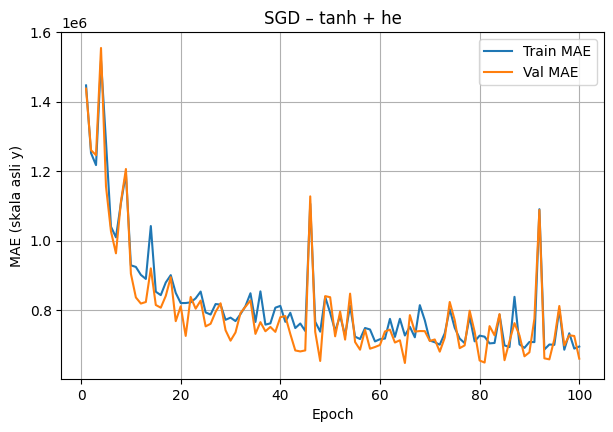

Epoch   10 | Train MAE = 800141.3511 | Val MAE = 756617.2977
Epoch   20 | Train MAE = 756824.2637 | Val MAE = 757077.5584
Epoch   30 | Train MAE = 757051.3044 | Val MAE = 733144.0968
Epoch   40 | Train MAE = 921591.2189 | Val MAE = 916216.7285
Epoch   50 | Train MAE = 764342.0050 | Val MAE = 765268.6268
Epoch   60 | Train MAE = 698172.1869 | Val MAE = 717450.7355
Epoch   70 | Train MAE = 707035.8815 | Val MAE = 677589.1515
Epoch   80 | Train MAE = 747727.1784 | Val MAE = 734331.2238
Epoch   90 | Train MAE = 709478.0300 | Val MAE = 679992.3267
Epoch  100 | Train MAE = 698713.0359 | Val MAE = 707545.0110


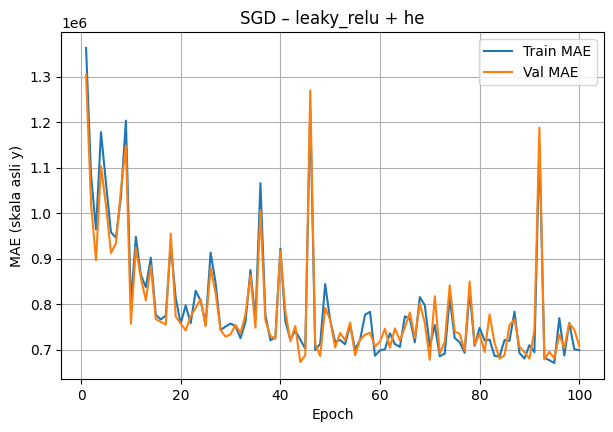

In [27]:
#STOCHASTIC GRADIENT DESCENT
#relu
W1, b1, W2, b2, hist_sgd = stoch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='relu', winit='he',
    shuffle=True, seed=42, log_every=1
)
plot_learning_curve(hist_sgd, title="SGD – relu + he")

#tanh
W1, b1, W2, b2, hist_sgd = stoch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='tanh', winit='he',
    shuffle=True, seed=42, log_every=1
)
plot_learning_curve(hist_sgd, title="SGD – tanh + he")

#leaky relu
W1, b1, W2, b2, hist_sgd = stoch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='leaky_relu', winit='he',
    shuffle=True, seed=42, log_every=1
)
plot_learning_curve(hist_sgd, title="SGD – leaky_relu + he")

Epoch   10 | Train MAE = 1926353.7217 | Val MAE = 2032177.3485
Epoch   20 | Train MAE = 1687712.7510 | Val MAE = 1728276.0179
Epoch   30 | Train MAE = 1528276.6849 | Val MAE = 1504509.3561
Epoch   40 | Train MAE = 1384016.7586 | Val MAE = 1347229.6434
Epoch   50 | Train MAE = 1309325.8541 | Val MAE = 1220574.7565
Epoch   60 | Train MAE = 1236377.5762 | Val MAE = 1162443.0030
Epoch   70 | Train MAE = 1179741.1962 | Val MAE = 1087689.4951
Epoch   80 | Train MAE = 1143473.0121 | Val MAE = 1051435.5905
Epoch   90 | Train MAE = 1105934.7546 | Val MAE = 1013991.8163
Epoch  100 | Train MAE = 1078115.4182 | Val MAE = 990660.9860


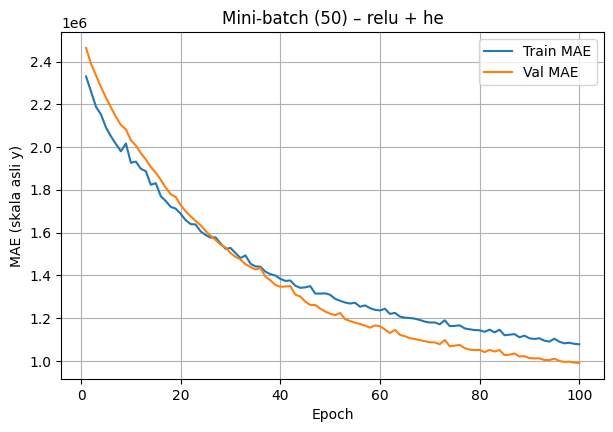

Epoch   10 | Train MAE = 2196446.9697 | Val MAE = 2201702.8012
Epoch   20 | Train MAE = 1823044.2237 | Val MAE = 1757296.5715
Epoch   30 | Train MAE = 1647457.5720 | Val MAE = 1599285.3949
Epoch   40 | Train MAE = 1515821.2090 | Val MAE = 1462884.4077
Epoch   50 | Train MAE = 1444079.2710 | Val MAE = 1409748.4660
Epoch   60 | Train MAE = 1365590.0745 | Val MAE = 1314151.8219
Epoch   70 | Train MAE = 1318340.4585 | Val MAE = 1271421.2937
Epoch   80 | Train MAE = 1285991.6202 | Val MAE = 1241101.9592
Epoch   90 | Train MAE = 1241756.2222 | Val MAE = 1191805.8391
Epoch  100 | Train MAE = 1222998.2215 | Val MAE = 1171152.7680


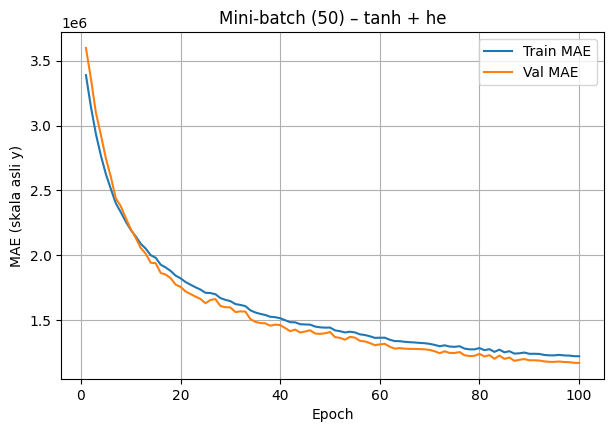

Epoch   10 | Train MAE = 1851126.0247 | Val MAE = 2024311.7679
Epoch   20 | Train MAE = 1613241.1961 | Val MAE = 1715761.0169
Epoch   30 | Train MAE = 1473550.2829 | Val MAE = 1490225.4815
Epoch   40 | Train MAE = 1332198.0510 | Val MAE = 1328240.2662
Epoch   50 | Train MAE = 1267622.0212 | Val MAE = 1197113.2712
Epoch   60 | Train MAE = 1192415.2784 | Val MAE = 1142193.7961
Epoch   70 | Train MAE = 1144452.6228 | Val MAE = 1066296.7540
Epoch   80 | Train MAE = 1115921.4329 | Val MAE = 1043097.6924
Epoch   90 | Train MAE = 1084294.5865 | Val MAE = 1016285.1035
Epoch  100 | Train MAE = 1063183.6531 | Val MAE = 1000035.0311


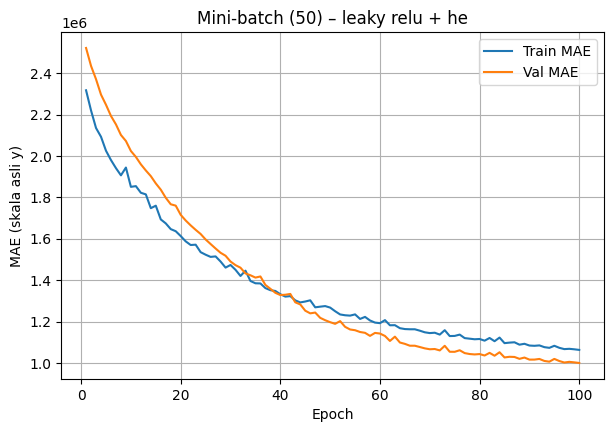

In [28]:
#BATCH GRADIENT DESCENT
#relu
W1, b1, W2, b2, hist_minib = mini_batch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='relu', winit='he',
    batch_size=50, shuffle=True, seed=42, log_every=1
)
plot_learning_curve(hist_minib, title="Mini-batch (50) – relu + he")
#tanh
W1, b1, W2, b2, hist_minib = mini_batch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='tanh', winit='he',
    batch_size=50, shuffle=True, seed=42, log_every=1
)
plot_learning_curve(hist_minib, title="Mini-batch (50) – tanh + he")
#leaky relu
W1, b1, W2, b2, hist_minib = mini_batch_gradient_descent(
    X_train_array, Y_train_array,
    epochs=100, lr=0.01, hidden_neuron=32,
    activation='leaky_relu', winit='he',
    batch_size=50, shuffle=True, seed=42, log_every=1
)
plot_learning_curve(hist_minib, title="Mini-batch (50) – leaky relu + he")